# THOMAS MCDONNELL QUANT TRADING STRATEGIES HW 4: ACCUMULATION ALGORITHM

In [108]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import plotnine as p9
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
from pandas import DateOffset
from plotnine import *
from plotnine.data import *
import patchworklib as pw

import warnings

# Suppress the warning
warnings.filterwarnings("ignore")

In [109]:
#TRADE 2021
BTC_USD_TRADE_2021 = pd.read_table('/Users/tmac/Downloads/trades_narrow_BTC-USD_2021.delim.gz', compression = 'gzip', sep = '\t')
ETH_BTC_TRADE_2021 = pd.read_table('/Users/tmac/Downloads/trades_narrow_ETH-BTC_2021.delim.gz', compression = 'gzip', sep = '\t')
ETH_USD_TRADE_2021 = pd.read_table('/Users/tmac/Downloads/trades_narrow_ETH-USD_2021.delim.gz', compression = 'gzip', sep = '\t')

#TRADE 2022
BTC_USD_TRADE_2022 = pd.read_table('/Users/tmac/Downloads/trades_narrow_BTC-USD_2022.delim.gz', compression = 'gzip', sep = '\t')
ETH_BTC_TRADE_2022 = pd.read_table('/Users/tmac/Downloads/trades_narrow_ETH-BTC_2022.delim.gz', compression = 'gzip', sep = '\t')
ETH_USD_TRADE_2022 = pd.read_table('/Users/tmac/Downloads/trades_narrow_ETH-USD_2022.delim.gz', compression = 'gzip', sep = '\t')

#TRADE 2023
BTC_USD_TRADE_2023 = pd.read_table('/Users/tmac/Downloads/trades_narrow_BTC-USD_2023.delim.gz', compression = 'gzip', sep = '\t')
ETH_BTC_TRADE_2023 = pd.read_table('/Users/tmac/Downloads/trades_narrow_ETH-BTC_2023.delim.gz', compression = 'gzip', sep = '\t')
ETH_USD_TRADE_2023 = pd.read_table('/Users/tmac/Downloads/trades_narrow_ETH-USD_2023.delim.gz', compression = 'gzip', sep = '\t')

In [110]:
BTC_USD = pd.concat([BTC_USD_TRADE_2021, BTC_USD_TRADE_2022, BTC_USD_TRADE_2023])
ETH_USD = pd.concat([ETH_USD_TRADE_2021, ETH_USD_TRADE_2022, ETH_USD_TRADE_2023])
ETH_BTC = pd.concat([ETH_BTC_TRADE_2021, ETH_BTC_TRADE_2022, ETH_BTC_TRADE_2023])

In [111]:
BTC_USD['price'] = BTC_USD['PriceMillionths']/1000000
BTC_USD['size'] = BTC_USD['SizeBillionths']/1000000000

ETH_USD['price'] = ETH_USD['PriceMillionths']/1000000
ETH_USD['size'] = ETH_USD['SizeBillionths']/1000000000

ETH_BTC['price'] = ETH_BTC['PriceMillionths']/1000000
ETH_BTC['size'] = ETH_BTC['SizeBillionths']/1000000000

In [112]:
BTC_USD['timestamp'] = BTC_USD['timestamp_utc_nanoseconds'].apply(lambda x: pd.Timestamp(x, unit='ns'))
ETH_USD['timestamp'] = ETH_USD['timestamp_utc_nanoseconds'].apply(lambda x: pd.Timestamp(x, unit='ns'))
ETH_BTC['timestamp'] = ETH_BTC['timestamp_utc_nanoseconds'].apply(lambda x: pd.Timestamp(x, unit='ns'))

In [113]:
def accumulation_algorithm(Q, T, p, trade_data, mins, side, crypto = False):
    start_time = pd.Timestamp(T, unit = 'ns')
    delta = pd.Timedelta(minutes = mins)
    
    mask = (trade_data['timestamp'] >= start_time - delta) & (trade_data['timestamp'] <= start_time + delta)
    df = trade_data[mask]
    df['rounded_time'] = df['timestamp'].dt.round('100ms')
    if side > 0:
        df = df[df['Side'] > 0]
        result = df.groupby(['rounded_time'])['price', 'size'].agg({'price': 'max', 'size': 'sum'})
    else:
        df = df[df['Side'] < 0]
        result = df.groupby(['rounded_time'])['price', 'size'].agg({'price': 'min', 'size': 'sum'})
    quant = 0
    count = 0
    ret_dict = {'transaction_costs': 0, 'total_spent': 0}
    for index, row in result.iterrows():
        quant += row['size'] * p
        count += 1
        ret_dict['total_spent'] += row['size'] * row['price'] * p
        if quant > Q:
            diff = quant - Q
            ret_dict['total_spent'] -= diff * row['price']
            result = result.reset_index()
            index = pd.to_datetime(index)
            ret_dict['quantity'] = Q
            ret_dict['minutes_spent'] = (index - pd.to_datetime(result.iloc[0]['rounded_time'])).total_seconds()/60
            ret_dict['avg_price'] = ret_dict['total_spent']/Q
            ret_dict['total_trades'] = count
            if crypto == True:
                ret_dict['transaction_costs'] = ret_dict['total_spent'] * .001
            else:
                 ret_dict['transaction_costs'] = ret_dict['total_spent'] * .005
            ret_dict['price_difference'] = ret_dict['avg_price'] - result.iloc[0]['price']
            if ret_dict['minutes_spent'] != 0:
                ret_dict['notional/time'] = (ret_dict['total_spent'] + ret_dict['transaction_costs'])/ret_dict['minutes_spent']
            else:
                ret_dict['notional/time'] = Q
            return ret_dict
            
            
    print('unable to accumulate this amount in the time constraint!')
    return 0

            


In [114]:
#every hour for BTC buys 2021
l = []
for i in range(10):
    dt = datetime(2021, 4, 11, i, 0, 0)
    timestamp = int(dt.timestamp() * 1e9)
    l.append(timestamp)
x = {}
for time in l:
    s = accumulation_algorithm(1, time, .05, BTC_USD, 15, 1)
    x[time] = s
df_BTC_USD_2021_B = pd.DataFrame.from_dict(x, orient='index')
df_BTC_USD_2021_B = df_BTC_USD_2021_B.reset_index()
df_BTC_USD_2021_B['date'] = pd.to_datetime(df_BTC_USD_2021_B['index'])
df_BTC_USD_2021_B['name'] = 'df_BTC_USD_2021_B'
#every hour for BTC buys 2022
j = []
for i in range(10):
    dt = datetime(2022, 1, 30, i, 0, 0)
    timestamp = int(dt.timestamp() * 1e9)
    j.append(timestamp)
x1 = {}
for time1 in j:
    s = accumulation_algorithm(1, time1, .05, BTC_USD, 15, 1)
    x1[time1] = s
df_BTC_USD_2022_B = pd.DataFrame.from_dict(x1, orient='index')
df_BTC_USD_2022_B = df_BTC_USD_2022_B.reset_index()
df_BTC_USD_2022_B['date'] = pd.to_datetime(df_BTC_USD_2022_B['index'])
df_BTC_USD_2022_B['name'] = 'df_BTC_USD_2022_B'

#every hour for BTC buys 2023
j = []
for i in range(10):
    dt = datetime(2023, 1, 25, i, 0, 0)
    timestamp = int(dt.timestamp() * 1e9)
    j.append(timestamp)
x1 = {}
for time1 in j:
    s = accumulation_algorithm(1, time1, .05, BTC_USD, 15, 1)
    x1[time1] = s
df_BTC_USD_2023_B = pd.DataFrame.from_dict(x1, orient='index')
df_BTC_USD_2023_B = df_BTC_USD_2023_B.reset_index()
df_BTC_USD_2023_B['date'] = pd.to_datetime(df_BTC_USD_2023_B['index'])
df_BTC_USD_2023_B['name'] = 'df_BTC_USD_2023_B'

In [115]:
#every hour for BTC sells 2021
l = []
for i in range(10):
    dt = datetime(2021, 4, 11, i, 0, 0)
    timestamp = int(dt.timestamp() * 1e9)
    l.append(timestamp)
x = {}
for time in l:
    s = accumulation_algorithm(1, time, .05, BTC_USD, 15, -1)
    x[time] = s
df_BTC_USD_2021_S = pd.DataFrame.from_dict(x, orient='index')
df_BTC_USD_2021_S = df_BTC_USD_2021_S.reset_index()
df_BTC_USD_2021_S['date'] = pd.to_datetime(df_BTC_USD_2021_S['index'])
df_BTC_USD_2021_S['name'] = 'df_BTC_USD_2021_S'

#every hour for BTC sells 2022
j = []
for i in range(10):
    dt = datetime(2022, 1, 30, i, 0, 0)
    timestamp = int(dt.timestamp() * 1e9)
    j.append(timestamp)
x1 = {}
for time1 in j:
    s = accumulation_algorithm(1, time1, .05, BTC_USD, 15, -1)
    x1[time1] = s
df_BTC_USD_2022_S = pd.DataFrame.from_dict(x1, orient='index')
df_BTC_USD_2022_S = df_BTC_USD_2022_S.reset_index()
df_BTC_USD_2022_S['date'] = pd.to_datetime(df_BTC_USD_2022_S['index'])
df_BTC_USD_2022_S['name'] = 'df_BTC_USD_2022_S'

#every hour for BTC sells 2023
j = []
for i in range(10):
    dt = datetime(2023, 1, 25, i, 0, 0)
    timestamp = int(dt.timestamp() * 1e9)
    j.append(timestamp)
x1 = {}
for time1 in j:
    s = accumulation_algorithm(1, time1, .05, BTC_USD, 15, -1)
    x1[time1] = s
df_BTC_USD_2023_S = pd.DataFrame.from_dict(x1, orient='index')
df_BTC_USD_2023_S = df_BTC_USD_2023_S.reset_index()
df_BTC_USD_2023_S['date'] = pd.to_datetime(df_BTC_USD_2023_S['index'])
df_BTC_USD_2023_S['name'] = 'df_BTC_USD_2023_S'

In [116]:
#every hour for ETH buys 2021
l = []
for i in range(10):
    dt = datetime(2021, 4, 11, i, 0, 0)
    timestamp = int(dt.timestamp() * 1e9)
    l.append(timestamp)
x = {}
for time in l:
    s = accumulation_algorithm(10, time, .05, ETH_USD, 15, 1)
    x[time] = s
df_ETH_USD_2021_B = pd.DataFrame.from_dict(x, orient='index')
df_ETH_USD_2021_B = df_ETH_USD_2021_B.reset_index()
df_ETH_USD_2021_B['date'] = pd.to_datetime(df_ETH_USD_2021_B['index'])
df_ETH_USD_2021_B['name'] = 'df_ETH_USD_2021_B'

#every hour for ETH buys 2022
j = []
for i in range(10):
    dt = datetime(2022, 1, 30, i, 0, 0)
    timestamp = int(dt.timestamp() * 1e9)
    j.append(timestamp)
x1 = {}
for time1 in j:
    s = accumulation_algorithm(10, time1, .05, ETH_USD, 15, 1)
    x1[time1] = s
df_ETH_USD_2022_B = pd.DataFrame.from_dict(x1, orient='index')
df_ETH_USD_2022_B = df_ETH_USD_2022_B.reset_index()
df_ETH_USD_2022_B['date'] = pd.to_datetime(df_ETH_USD_2022_B['index'])
df_ETH_USD_2022_B['name'] = 'df_ETH_USD_2022_B'

#every hour for ETH buys 2023
j = []
for i in range(10):
    dt = datetime(2023, 1, 25, i, 0, 0)
    timestamp = int(dt.timestamp() * 1e9)
    j.append(timestamp)
x1 = {}
for time1 in j:
    s = accumulation_algorithm(10, time1, .05, ETH_USD, 15, 1)
    x1[time1] = s
df_ETH_USD_2023_B = pd.DataFrame.from_dict(x1, orient='index')
df_ETH_USD_2023_B = df_ETH_USD_2023_B.reset_index()
df_ETH_USD_2023_B['date'] = pd.to_datetime(df_ETH_USD_2023_B['index'])
df_ETH_USD_2023_B['name'] = 'df_ETH_USD_2023_B'

In [117]:
#every hour for ETH sells 2021
l = []
for i in range(10):
    dt = datetime(2021, 4, 11, i, 0, 0)
    timestamp = int(dt.timestamp() * 1e9)
    l.append(timestamp)
x = {}
for time in l:
    s = accumulation_algorithm(10, time, .05, ETH_USD, 15, -1)
    x[time] = s
df_ETH_USD_2021_S = pd.DataFrame.from_dict(x, orient='index')
df_ETH_USD_2021_S = df_ETH_USD_2021_S.reset_index()
df_ETH_USD_2021_S['date'] = pd.to_datetime(df_ETH_USD_2021_S['index'])
df_ETH_USD_2021_S['name'] = 'df_ETH_USD_2021_S'

#every hour for ETH sells 2022
j = []
for i in range(10):
    dt = datetime(2022, 1, 30, i, 0, 0)
    timestamp = int(dt.timestamp() * 1e9)
    j.append(timestamp)
x1 = {}
for time1 in j:
    s = accumulation_algorithm(10, time1, .05, ETH_USD, 15, -1)
    x1[time1] = s
df_ETH_USD_2022_S = pd.DataFrame.from_dict(x1, orient='index')
df_ETH_USD_2022_S = df_ETH_USD_2022_S.reset_index()
df_ETH_USD_2022_S['date'] = pd.to_datetime(df_ETH_USD_2022_S['index'])
df_ETH_USD_2022_S['name'] = 'df_ETH_USD_2022_S'

#every hour for ETH sells 2023
j = []
for i in range(10):
    dt = datetime(2023, 1, 25, i, 0, 0)
    timestamp = int(dt.timestamp() * 1e9)
    j.append(timestamp)
x1 = {}
for time1 in j:
    s = accumulation_algorithm(10, time1, .05, ETH_USD, 15, -1)
    x1[time1] = s
df_ETH_USD_2023_S = pd.DataFrame.from_dict(x1, orient='index')
df_ETH_USD_2023_S = df_ETH_USD_2023_S.reset_index()
df_ETH_USD_2023_S['date'] = pd.to_datetime(df_ETH_USD_2023_S['index'])
df_ETH_USD_2023_S['name'] = 'df_ETH_USD_2023_S'

In [118]:
#every hour for ETH/BTC buys 2021
l = []
for i in range(10):
    dt = datetime(2021, 4, 11, i, 0, 0)
    timestamp = int(dt.timestamp() * 1e9)
    l.append(timestamp)
x = {}
for time in l:
    s = accumulation_algorithm(.5, time, .05, ETH_BTC, 15, 1)
    x[time] = s
df_ETH_BTC_2021_B = pd.DataFrame.from_dict(x, orient='index')
df_ETH_BTC_2021_B = df_ETH_BTC_2021_B.reset_index()
df_ETH_BTC_2021_B['date'] = pd.to_datetime(df_ETH_BTC_2021_B['index'])
df_ETH_BTC_2021_B['name'] = 'df_ETH_BTC_2021_B'
df_ETH_BTC_2021_B['transaction_costs'] *= BTC_USD_TRADE_2021['PriceMillionths'].mean()/1000000
df_ETH_BTC_2021_B['notional/time'] *= BTC_USD_TRADE_2021['PriceMillionths'].mean()/1000000
df_ETH_BTC_2021_B['price_difference'] *= BTC_USD_TRADE_2021['PriceMillionths'].mean()/1000000

#every hour for ETH/BTC buys 2022
j = []
for i in range(10):
    dt = datetime(2022, 1, 30, i, 0, 0)
    timestamp = int(dt.timestamp() * 1e9)
    j.append(timestamp)
x1 = {}
for time1 in j:
    s = accumulation_algorithm(.5, time1, .05, ETH_BTC, 15, 1)
    x1[time1] = s
df_ETH_BTC_2022_B = pd.DataFrame.from_dict(x1, orient='index')
df_ETH_BTC_2022_B = df_ETH_BTC_2022_B.reset_index()
df_ETH_BTC_2022_B['date'] = pd.to_datetime(df_ETH_BTC_2022_B['index'])
df_ETH_BTC_2022_B['name'] = 'df_ETH_BTC_2022_B'
df_ETH_BTC_2022_B['notional/time'] *= BTC_USD_TRADE_2022['PriceMillionths'].mean()/1000000
df_ETH_BTC_2022_B['transaction_costs'] *= BTC_USD_TRADE_2022['PriceMillionths'].mean()/1000000
df_ETH_BTC_2022_B['price_difference'] *= BTC_USD_TRADE_2022['PriceMillionths'].mean()/1000000
#leaning out 2023 as there is not as much volume

In [119]:
#every hour for ETH/BTC sells 2021
l = []
for i in range(10):
    dt = datetime(2021, 4, 11, i, 0, 0)
    timestamp = int(dt.timestamp() * 1e9)
    l.append(timestamp)
x = {}
for time in l:
    s = accumulation_algorithm(.5, time, .05, ETH_BTC, 15, -1)
    x[time] = s
df_ETH_BTC_2021_S = pd.DataFrame.from_dict(x, orient='index')
df_ETH_BTC_2021_S = df_ETH_BTC_2021_S.reset_index()
df_ETH_BTC_2021_S['date'] = pd.to_datetime(df_ETH_BTC_2021_S['index'])
df_ETH_BTC_2021_S['name'] = 'df_ETH_BTC_2021_S'
df_ETH_BTC_2021_S['transaction_costs'] *= BTC_USD_TRADE_2021['PriceMillionths'].mean()/1000000
df_ETH_BTC_2021_S['notional/time'] *= BTC_USD_TRADE_2021['PriceMillionths'].mean()/1000000
df_ETH_BTC_2021_S['price_difference'] *= BTC_USD_TRADE_2021['PriceMillionths'].mean()/1000000


#every hour for ETH/BTC sells 2022
j = []
for i in range(10):
    dt = datetime(2022, 1, 30, i, 0, 0)
    timestamp = int(dt.timestamp() * 1e9)
    j.append(timestamp)
x1 = {}
for time1 in j:
    s = accumulation_algorithm(.5, time1, .05, ETH_BTC, 15, -1)
    x1[time1] = s
df_ETH_BTC_2022_S = pd.DataFrame.from_dict(x1, orient='index')
df_ETH_BTC_2022_S = df_ETH_BTC_2022_S.reset_index()
df_ETH_BTC_2022_S['date'] = pd.to_datetime(df_ETH_BTC_2022_S['index'])
df_ETH_BTC_2022_S['name'] = 'df_ETH_BTC_2022_S'
df_ETH_BTC_2022_S['transaction_costs'] *= BTC_USD_TRADE_2022['PriceMillionths'].mean()/1000000
df_ETH_BTC_2022_S['notional/time'] *= BTC_USD_TRADE_2022['PriceMillionths'].mean()/1000000
df_ETH_BTC_2022_S['price_difference'] *= BTC_USD_TRADE_2022['PriceMillionths'].mean()/1000000
#leaving out 2023 as there is not much volume

# 1 DATA

The data in this project consisted of individual trades between pairs of either a cryptocurrency and usd or two cryptocurrencies. The specific pairs used were BTC/USD, ETH/USD and ETH/BTC. I initially had 9 dataframes, trades for each of these pairs during 3 years. They weren't trades during the entire year but instead trades during about a two day time period at somepoint in the year. Since this was such high frequency data this still amounted to millions of trades. The important columns in these dataframes were 'timestamp_utc_nanoseconds' which was the timestamp down to the closest nanosecond that the trade was fulfilled. Then there were price and size columns which corresponded to the price of the cryptocurrency at which the trade was filled as well as the quantity. These were in size billionths and price millionths so I divided theses number by one billion and one million respectively. I also concatenated all of my dataframes for each pair so that I would have one dataframe with three years (two days during each year) of data and three dataframes to work with. 

# 2 SIMULATION

The goal of this project was to create an accumulation algorithm. An accumulation algorithm is an algorithm that attempts to split large trade orders up into small parts in order to get a better average price and lower transaction costs. My algorithm took in 7 parameters: Q, T, p, trade_data, mins, side and crypto (boolean). Q is the total quantity that you are looking to accumulate, for example 1 BTC. T is a timestamp in nanoseconds for the start time of your accumulation. P is the participation rate in the market. For example if your p is 5% then you would trade .05 * total market volume at that time. Trade_data is simply just the dataframe of historic trades. Mins is the amount of minutes that I am alloting for my algorithm. For example, if mins = 15 and I can't accumulate my whole Q during this time period my algorithm will print out that it is impossible to accumulate your specific quantity given the other constraints. Side is either -1 or 1 and if -1 then we are attempting a sell accumulation, if 1 then attempting a buy accumulation. The final variable, crypto is initially set to false and is only true when I am using ETH/BTC. The only thing that this variable effects is changing the transaction costs from 50 basis points to 10 basis points (which I will explain more about later).

The initial step in my algorithm is to create a boolean mask that shrinks my dataframe to only trades during X minutes after my start time (x in this case being the mins variable). This lets me loop through a much smaller dataframe and reduce compuation time. As mentioned in the assignment, if there are a flurry of trades during the same time period I must take the price of the 'worst' trade (highest for buy lowest for sell). To deal with this, I rounded my timestamp to the nearest 100 milleseconds which is the equivalent of .1 seconds. Now to get rid of duplicates and keep the total volume and worst price I used the groupby.agg function. This left me with a dataframe with a span of X minutes and entries that are no closer than 0.1 seconds apart with both price and volume. Also, if my side is -1, I only have sales in my dataframe and if it is 1 I only have buys. Now is time to loop throug this dataframe and accumulate.

The first step is simply to multiply the volume during that specific timestamp and the participation rate, and add that to a variable (initially 0) to track my total accumulated quantity. Then, to track my total amount spent I multiplied that quantity by the corresponding price and kept that value in a dictionary which I will eventually return. I continue to loop through the different trades and do these calculations until my accumulated quantity is greater than or equal to Q, my desired quantity. At this point, I delete the extra part that I may have bought from the trade to put me over, and delete that price. The reason for this is to get me to accumulate exactly Q, and this doesn't have lookahead bias it is simply a way that I went about simulating instead of using a while loop. This results in me having accumulated exactly Q. I then calculate metrics such as average price, minutes spent, and price difference (avg price - initial price). Finally, I must deal with transaction costs. For CRYPTO/USD the costs are 50bps and for CRYPTO/CRYPTO they are 10bps. To factor this in, I take my total spent and multiply it by either .005 or .001 (depending on if crypto = False or not). If I am unable to accumulate my desired amount in my specific timeframe then I will print out a message that the full accumulation isn't possible given the parameters. 

# 3 ANALYSIS

I decided to start my algorithm at 10 different hours during all three years for all three pairs for both buying and selling. This resulted in 16 (I didn't do ETH/BTC buy or sell for 2023 due to lack of volume) different outputs that were a dataframe with columns that included transaction costs, total costs, time spent, average price, total trades, price difference and notional/time. Below I have plotted price difference, notional/time and total trades for buys and sells of all three pairs in 2021 to give a representation of what some of the data looks like.

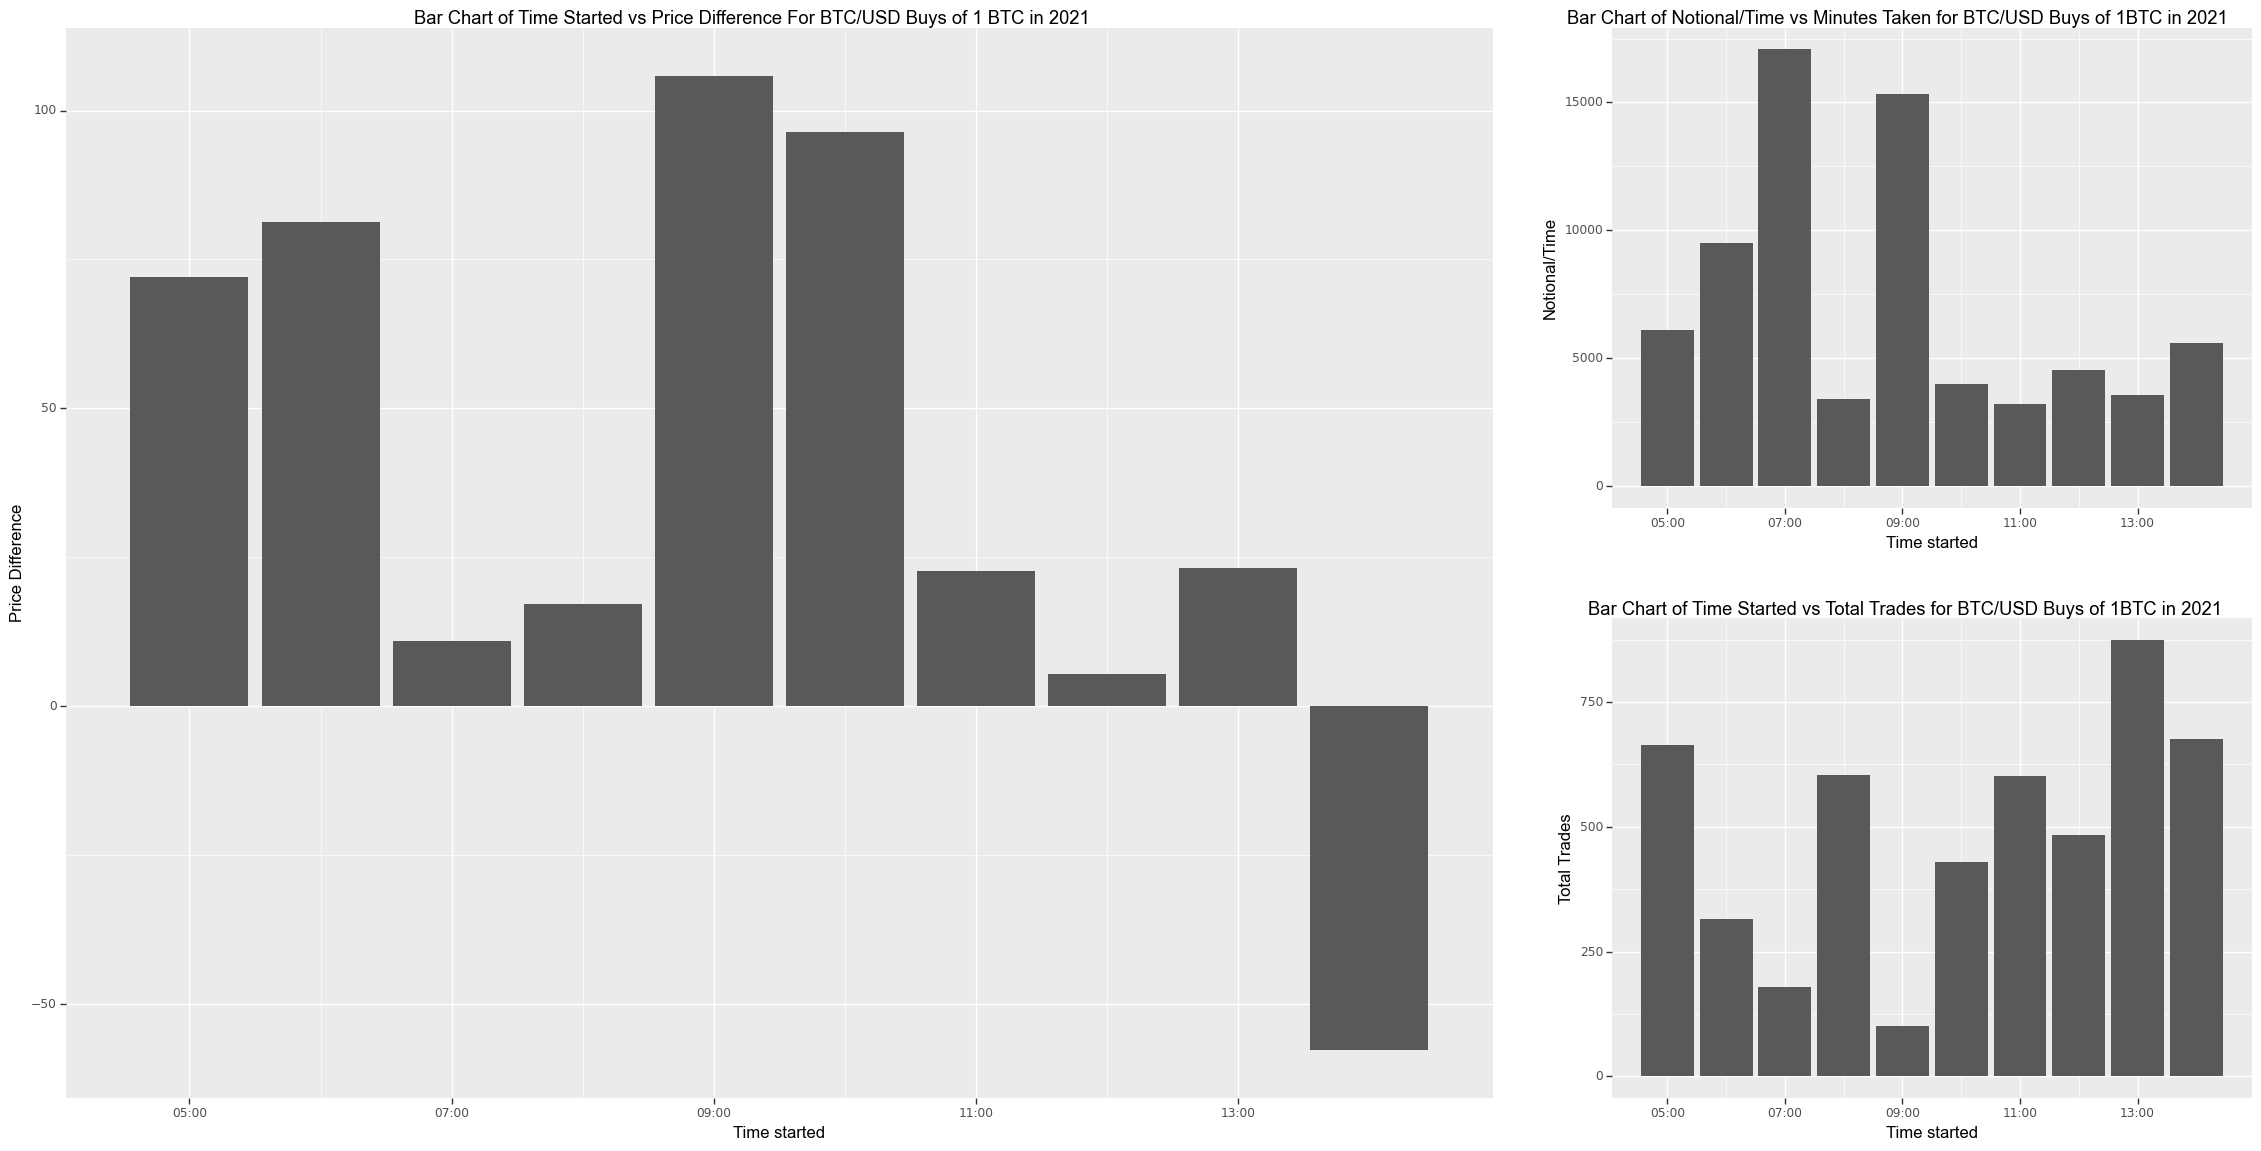

In [120]:
p1 = (ggplot(df_BTC_USD_2021_B, aes(x='date', y='notional/time')) +
 geom_bar(stat='identity') +
 scale_x_date(date_breaks = "2 hours", date_labels = "%H:%M")+
 xlab('Time started') +
 ylab('Notional/Time') +
 ggtitle('Bar Chart of Notional/Time vs Minutes Taken for BTC/USD Buys of 1BTC in 2021'))

p2 = (ggplot(df_BTC_USD_2021_B, aes(x='date', y='total_trades')) +
 geom_bar(stat='identity') +
 scale_x_date(date_breaks = "2 hours", date_labels = "%H:%M")+
 xlab('Time started') +
 ylab('Total Trades') +
 ggtitle('Bar Chart of Time Started vs Total Trades for BTC/USD Buys of 1BTC in 2021'))

p3 = (ggplot(df_BTC_USD_2021_B, aes(x='date', y='price_difference')) +
 geom_bar(stat='identity') +
 scale_x_date(date_breaks = "2 hours", date_labels = "%H:%M")+
 xlab('Time started') +
 ylab('Price Difference') +
 ggtitle('Bar Chart of Time Started vs Price Difference For BTC/USD Buys of 1 BTC in 2021'))
# figsize=(5,3))
p1 = pw.load_ggplot(p1)
p2 = pw.load_ggplot(p2)
p3 = pw.load_ggplot(p3)


p12 = ((p3 + p1/p2))
p12.savefig()

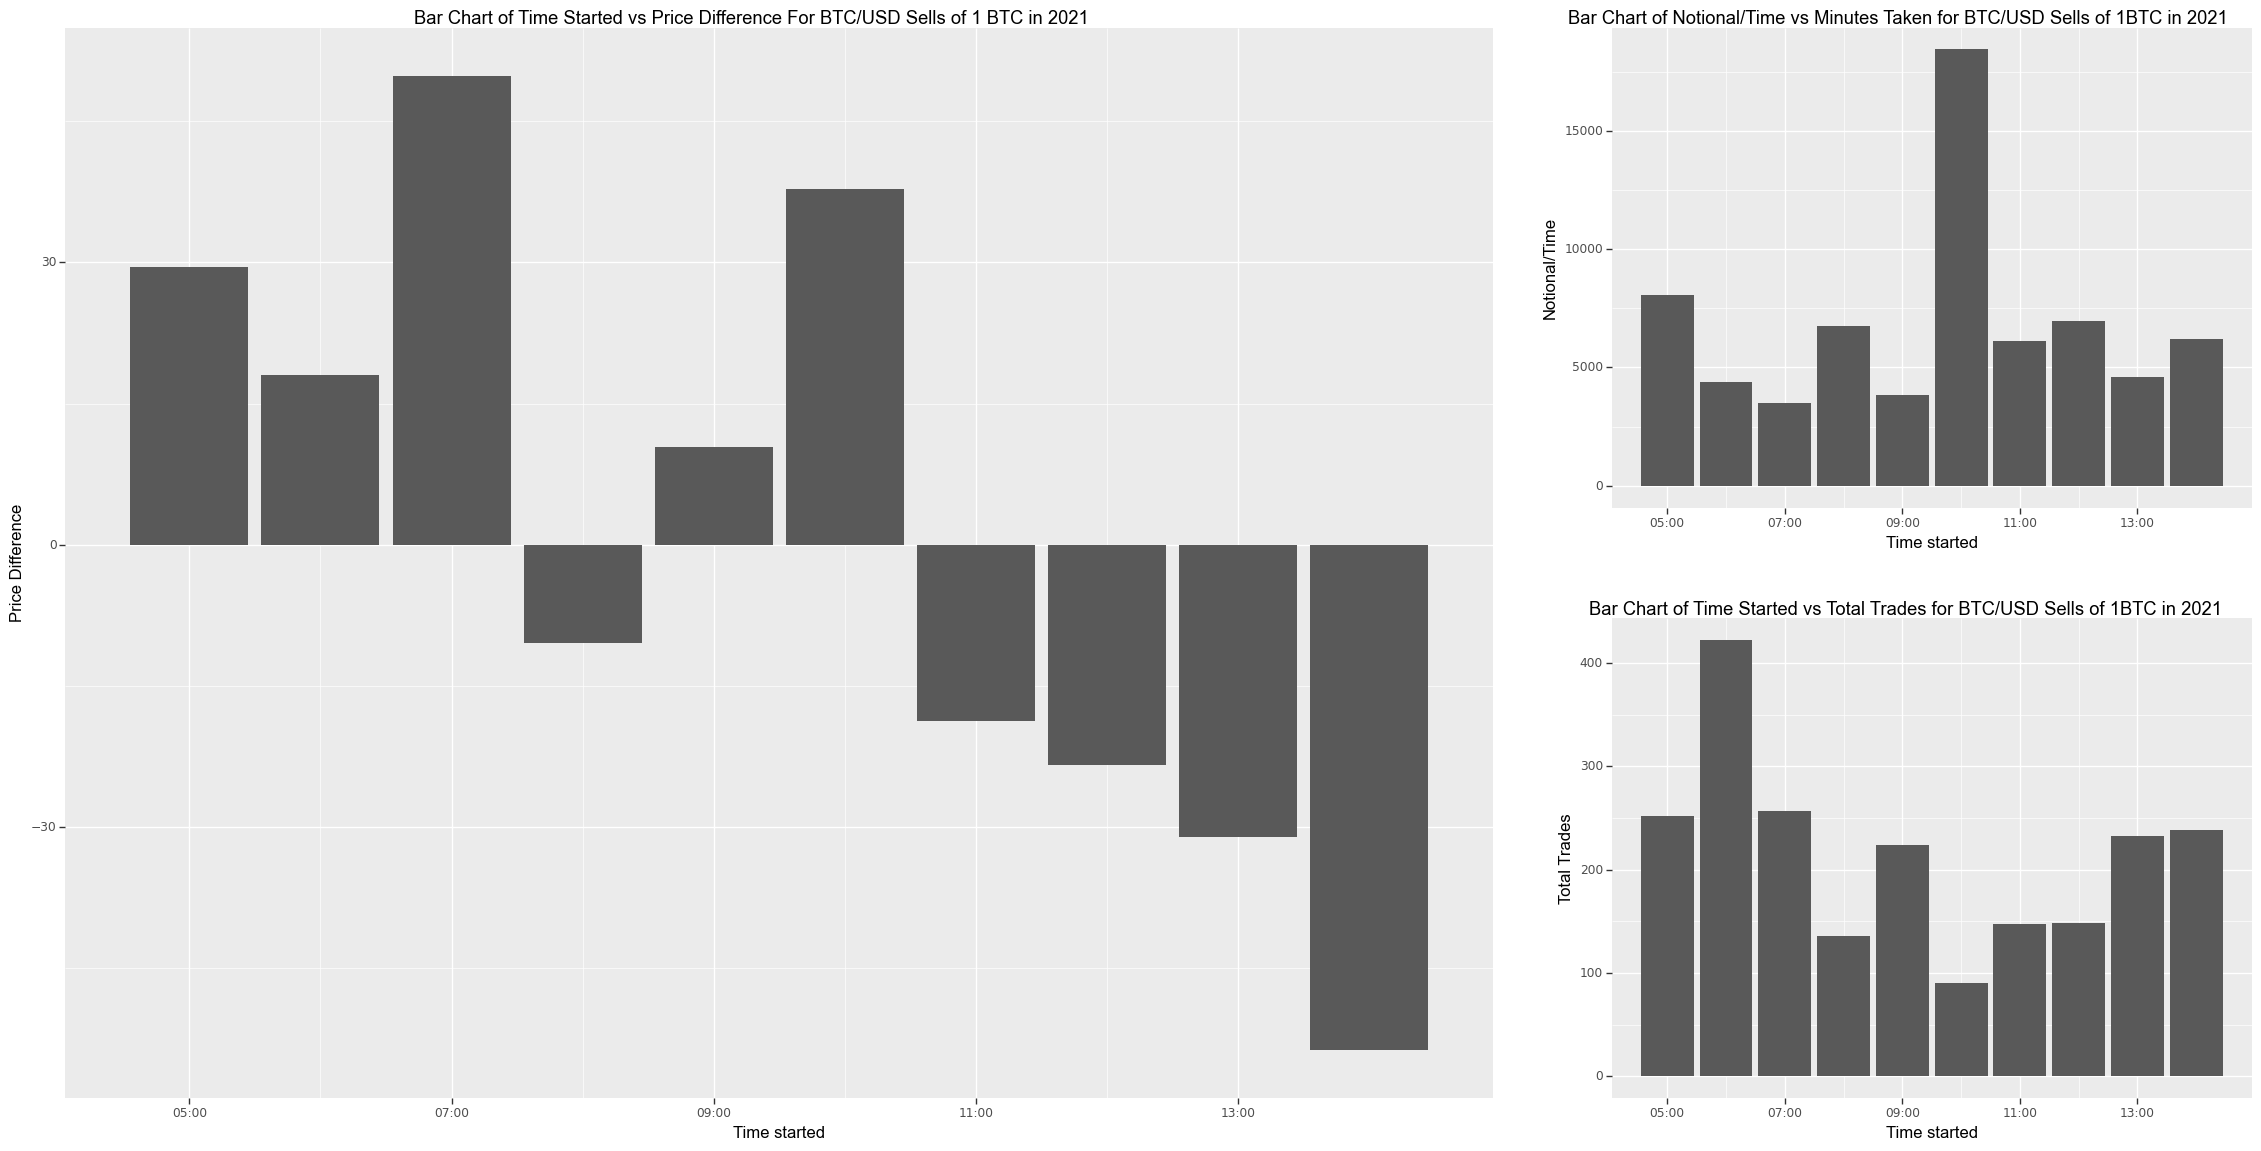

In [121]:
p1 = (ggplot(df_BTC_USD_2021_S, aes(x='date', y='notional/time')) +
 geom_bar(stat='identity') +
 scale_x_date(date_breaks = "2 hours", date_labels = "%H:%M")+
 xlab('Time started') +
 ylab('Notional/Time') +
 ggtitle('Bar Chart of Notional/Time vs Minutes Taken for BTC/USD Sells of 1BTC in 2021'))

p2 = (ggplot(df_BTC_USD_2021_S, aes(x='date', y='total_trades')) +
 geom_bar(stat='identity') +
 scale_x_date(date_breaks = "2 hours", date_labels = "%H:%M")+
 xlab('Time started') +
 ylab('Total Trades') +
 ggtitle('Bar Chart of Time Started vs Total Trades for BTC/USD Sells of 1BTC in 2021'))

p3 = (ggplot(df_BTC_USD_2021_S, aes(x='date', y='price_difference')) +
 geom_bar(stat='identity') +
 scale_x_date(date_breaks = "2 hours", date_labels = "%H:%M")+
 xlab('Time started') +
 ylab('Price Difference') +
 ggtitle('Bar Chart of Time Started vs Price Difference For BTC/USD Sells of 1 BTC in 2021'))
# figsize=(5,3))
p1 = pw.load_ggplot(p1)
p2 = pw.load_ggplot(p2)
p3 = pw.load_ggplot(p3)


p12 = ((p3 + p1/p2))
p12.savefig()

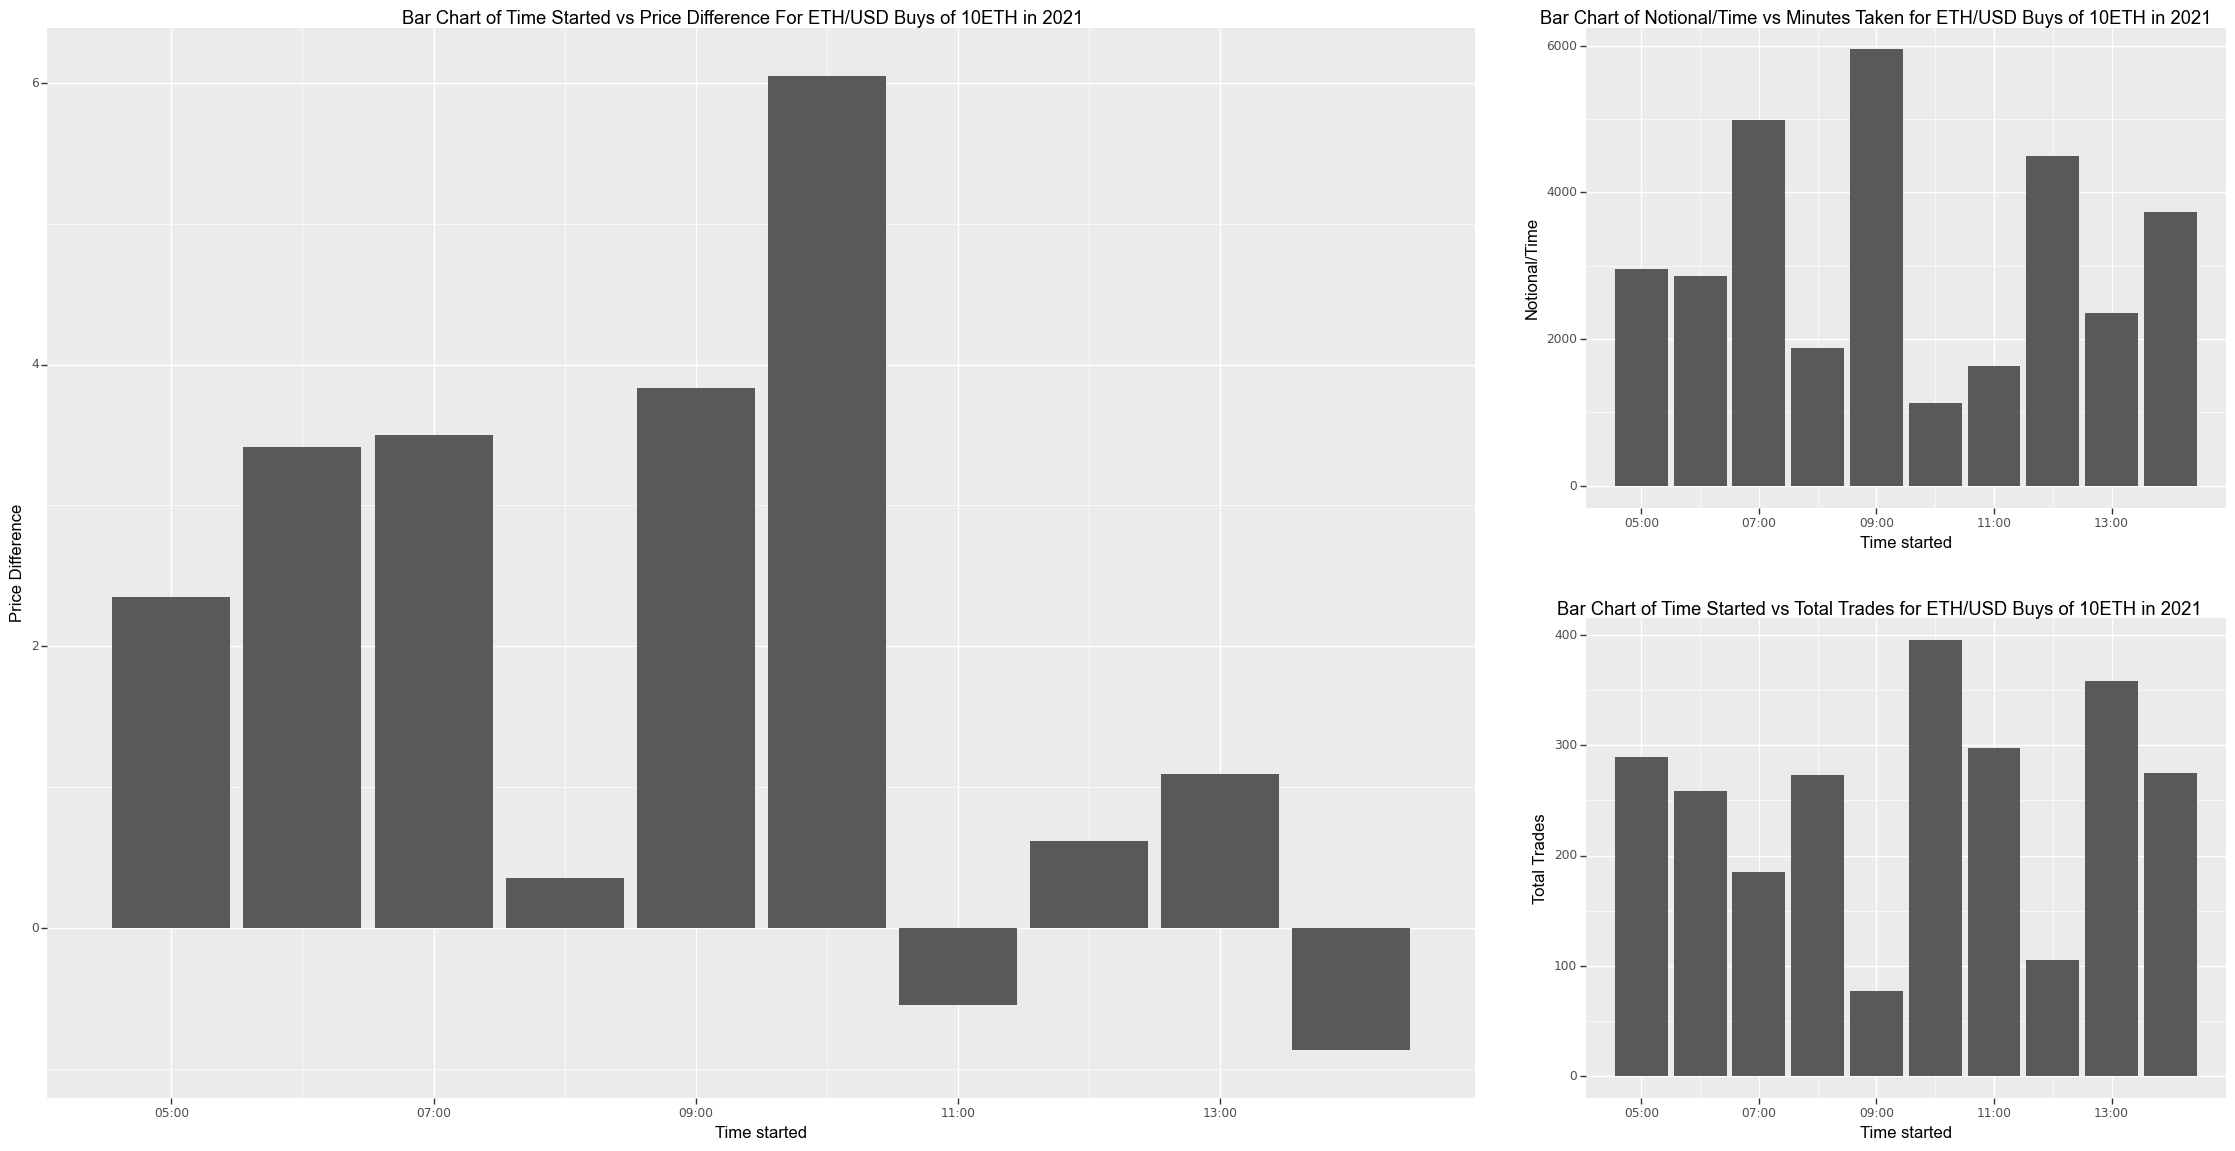

In [122]:
p1 = (ggplot(df_ETH_USD_2021_B, aes(x='date', y='notional/time')) +
 geom_bar(stat='identity') +
 scale_x_date(date_breaks = "2 hours", date_labels = "%H:%M")+
 xlab('Time started') +
 ylab('Notional/Time') +
 ggtitle('Bar Chart of Notional/Time vs Minutes Taken for ETH/USD Buys of 10ETH in 2021'))

p2 = (ggplot(df_ETH_USD_2021_B, aes(x='date', y='total_trades')) +
 geom_bar(stat='identity') +
 scale_x_date(date_breaks = "2 hours", date_labels = "%H:%M")+
 xlab('Time started') +
 ylab('Total Trades') +
 ggtitle('Bar Chart of Time Started vs Total Trades for ETH/USD Buys of 10ETH in 2021'))

p3 = (ggplot(df_ETH_USD_2021_B, aes(x='date', y='price_difference')) +
 geom_bar(stat='identity') +
 scale_x_date(date_breaks = "2 hours", date_labels = "%H:%M")+
 xlab('Time started') +
 ylab('Price Difference') +
 ggtitle('Bar Chart of Time Started vs Price Difference For ETH/USD Buys of 10ETH in 2021'))
# figsize=(5,3))
p1 = pw.load_ggplot(p1)
p2 = pw.load_ggplot(p2)
p3 = pw.load_ggplot(p3)


p12 = ((p3 + p1/p2))
p12.savefig()

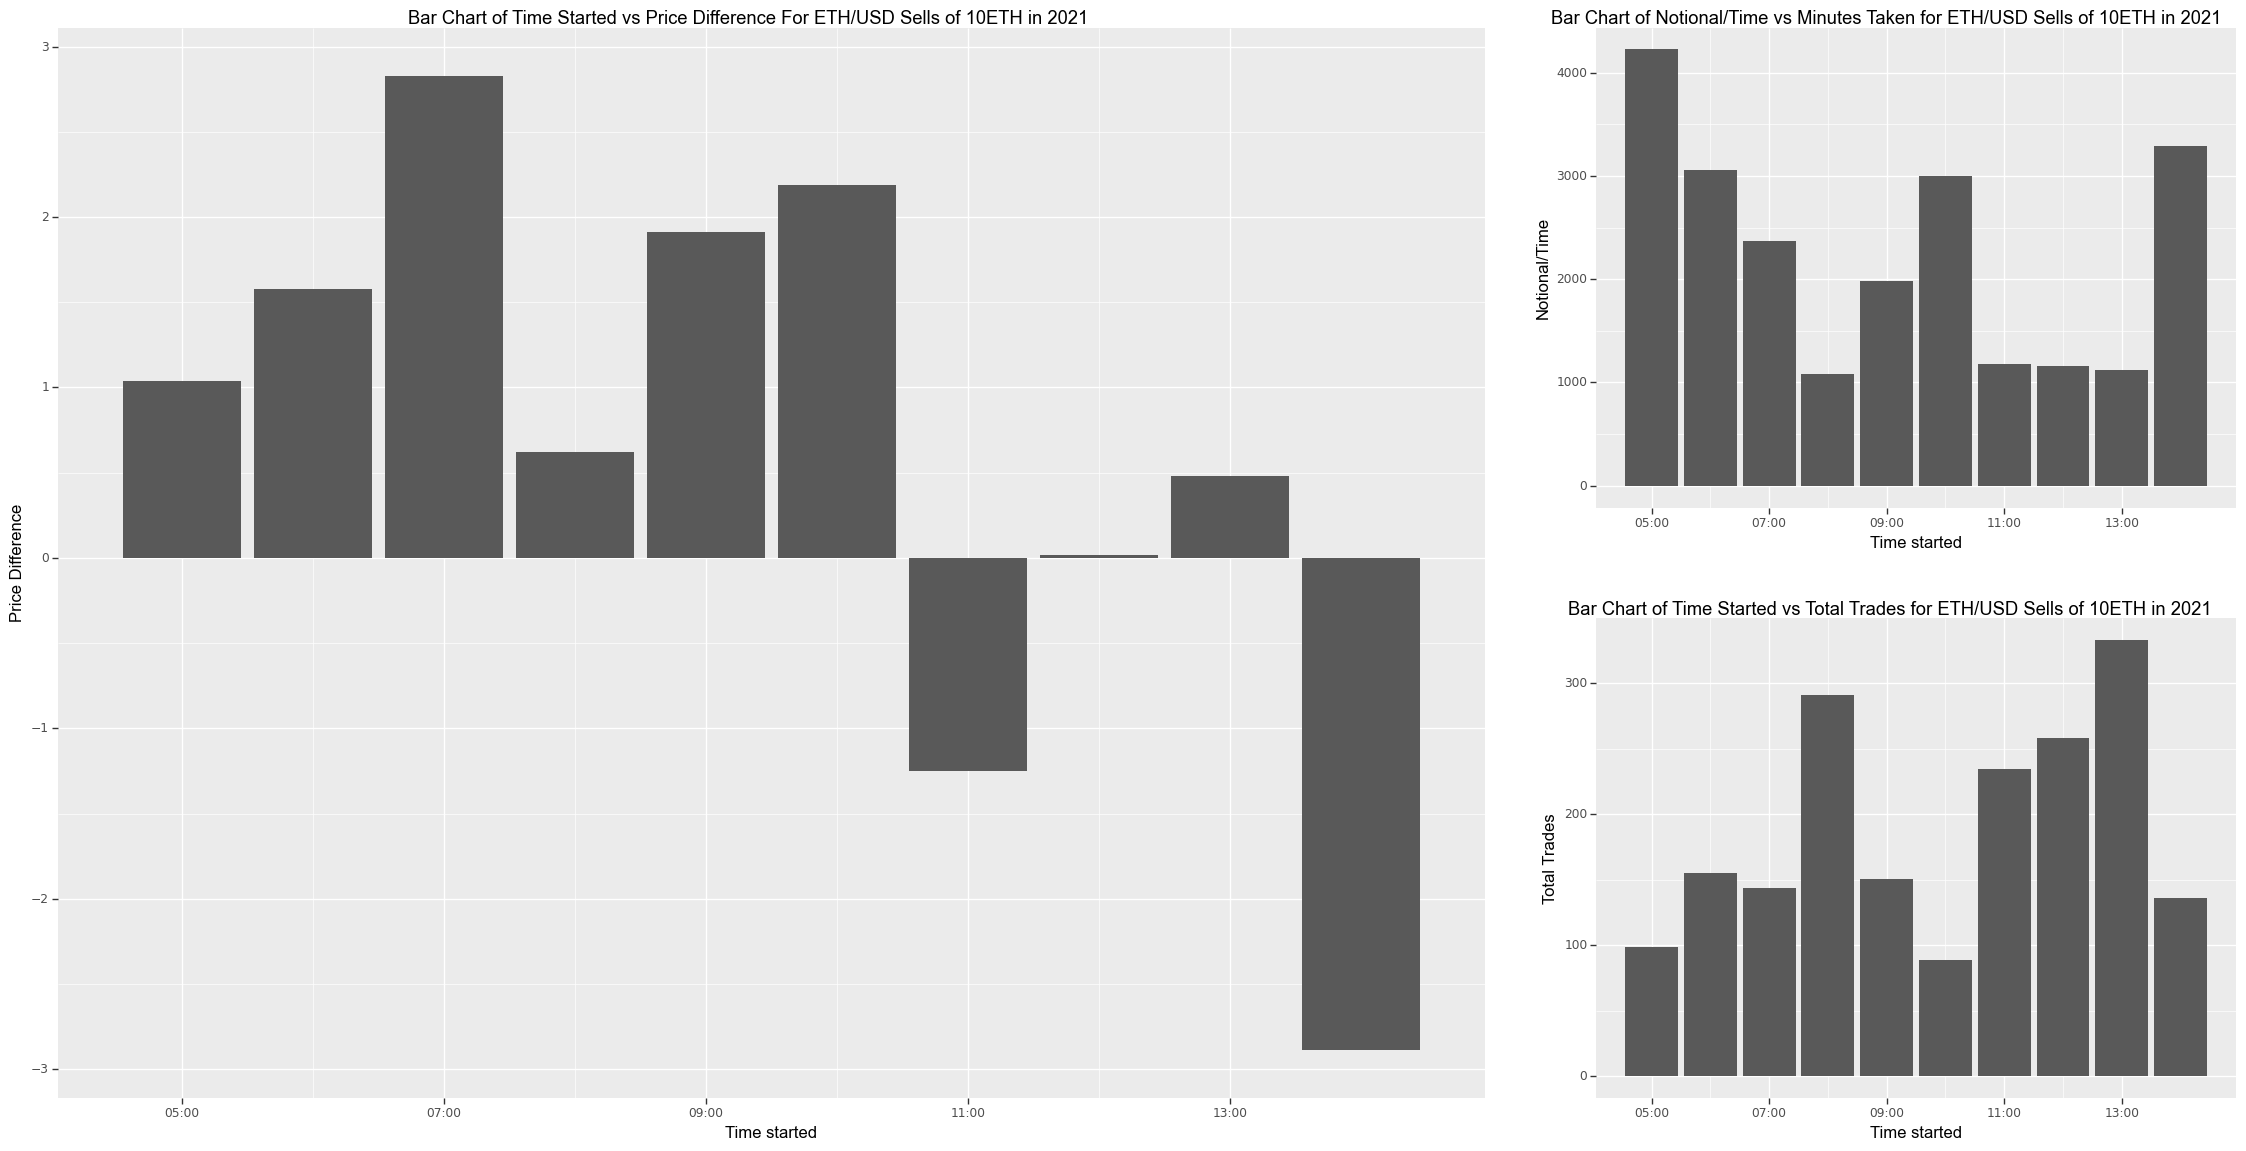

In [123]:
p1 = (ggplot(df_ETH_USD_2021_S, aes(x='date', y='notional/time')) +
 geom_bar(stat='identity') +
 scale_x_date(date_breaks = "2 hours", date_labels = "%H:%M")+
 xlab('Time started') +
 ylab('Notional/Time') +
 ggtitle('Bar Chart of Notional/Time vs Minutes Taken for ETH/USD Sells of 10ETH in 2021'))

p2 = (ggplot(df_ETH_USD_2021_S, aes(x='date', y='total_trades')) +
 geom_bar(stat='identity') +
 scale_x_date(date_breaks = "2 hours", date_labels = "%H:%M")+
 xlab('Time started') +
 ylab('Total Trades') +
 ggtitle('Bar Chart of Time Started vs Total Trades for ETH/USD Sells of 10ETH in 2021'))

p3 = (ggplot(df_ETH_USD_2021_S, aes(x='date', y='price_difference')) +
 geom_bar(stat='identity') +
 scale_x_date(date_breaks = "2 hours", date_labels = "%H:%M")+
 xlab('Time started') +
 ylab('Price Difference') +
 ggtitle('Bar Chart of Time Started vs Price Difference For ETH/USD Sells of 10ETH in 2021'))
# figsize=(5,3))
p1 = pw.load_ggplot(p1)
p2 = pw.load_ggplot(p2)
p3 = pw.load_ggplot(p3)


p12 = ((p3 + p1/p2))
p12.savefig()

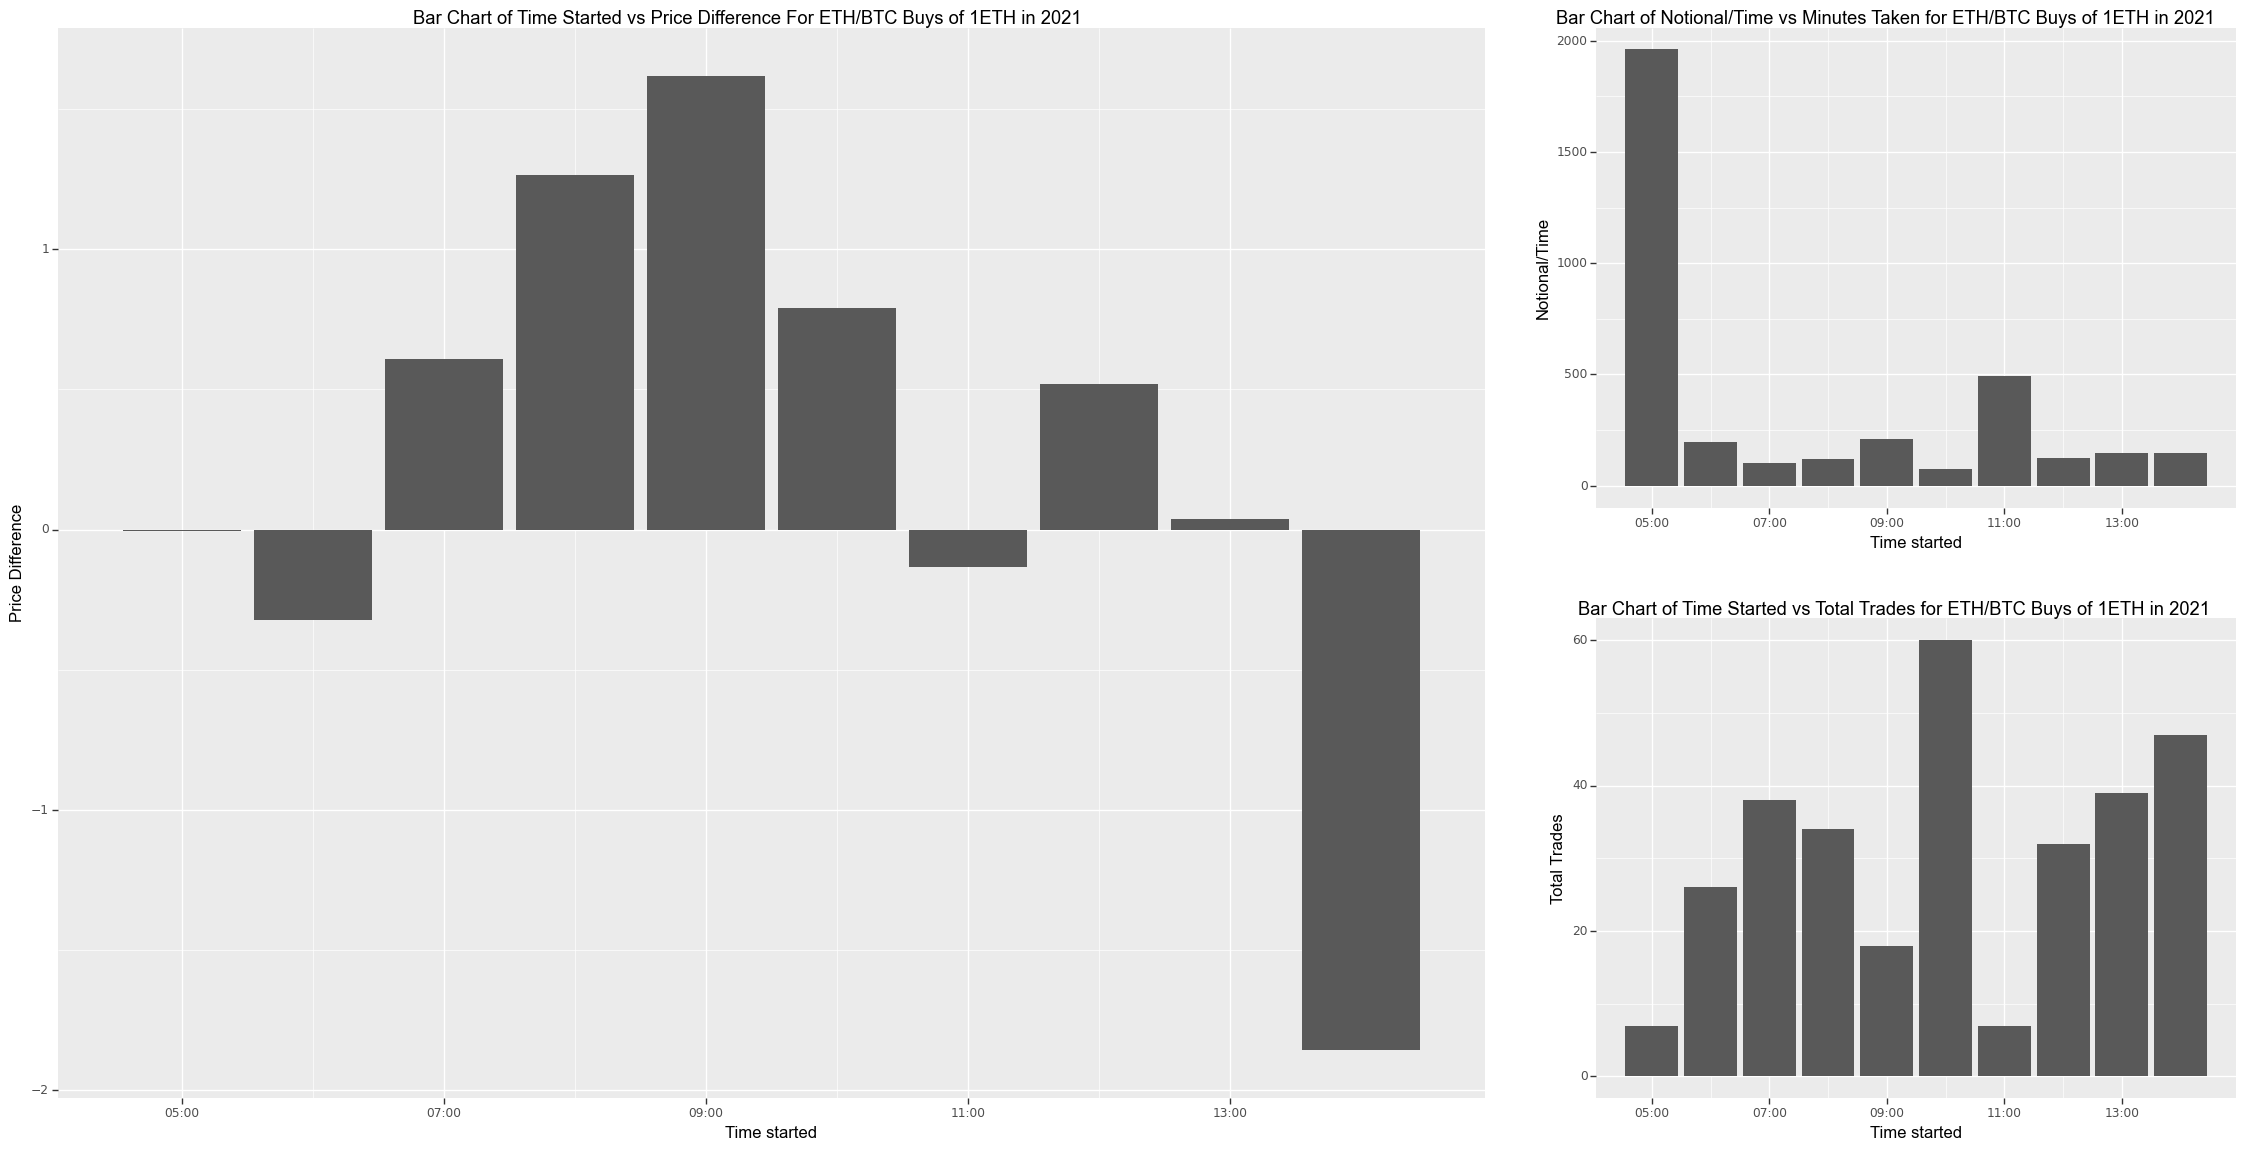

In [124]:
p1 = (ggplot(df_ETH_BTC_2021_B, aes(x='date', y='notional/time')) +
 geom_bar(stat='identity') +
 scale_x_date(date_breaks = "2 hours", date_labels = "%H:%M")+
 xlab('Time started') +
 ylab('Notional/Time') +
 ggtitle('Bar Chart of Notional/Time vs Minutes Taken for ETH/BTC Buys of 1ETH in 2021'))

p2 = (ggplot(df_ETH_BTC_2021_B, aes(x='date', y='total_trades')) +
 geom_bar(stat='identity') +
 scale_x_date(date_breaks = "2 hours", date_labels = "%H:%M")+
 xlab('Time started') +
 ylab('Total Trades') +
 ggtitle('Bar Chart of Time Started vs Total Trades for ETH/BTC Buys of 1ETH in 2021'))

p3 = (ggplot(df_ETH_BTC_2021_B, aes(x='date', y='price_difference')) +
 geom_bar(stat='identity') +
 scale_x_date(date_breaks = "2 hours", date_labels = "%H:%M")+
 xlab('Time started') +
 ylab('Price Difference') +
 ggtitle('Bar Chart of Time Started vs Price Difference For ETH/BTC Buys of 1ETH in 2021'))
# figsize=(5,3))
p1 = pw.load_ggplot(p1)
p2 = pw.load_ggplot(p2)
p3 = pw.load_ggplot(p3)


p12 = ((p3 + p1/p2))
p12.savefig()

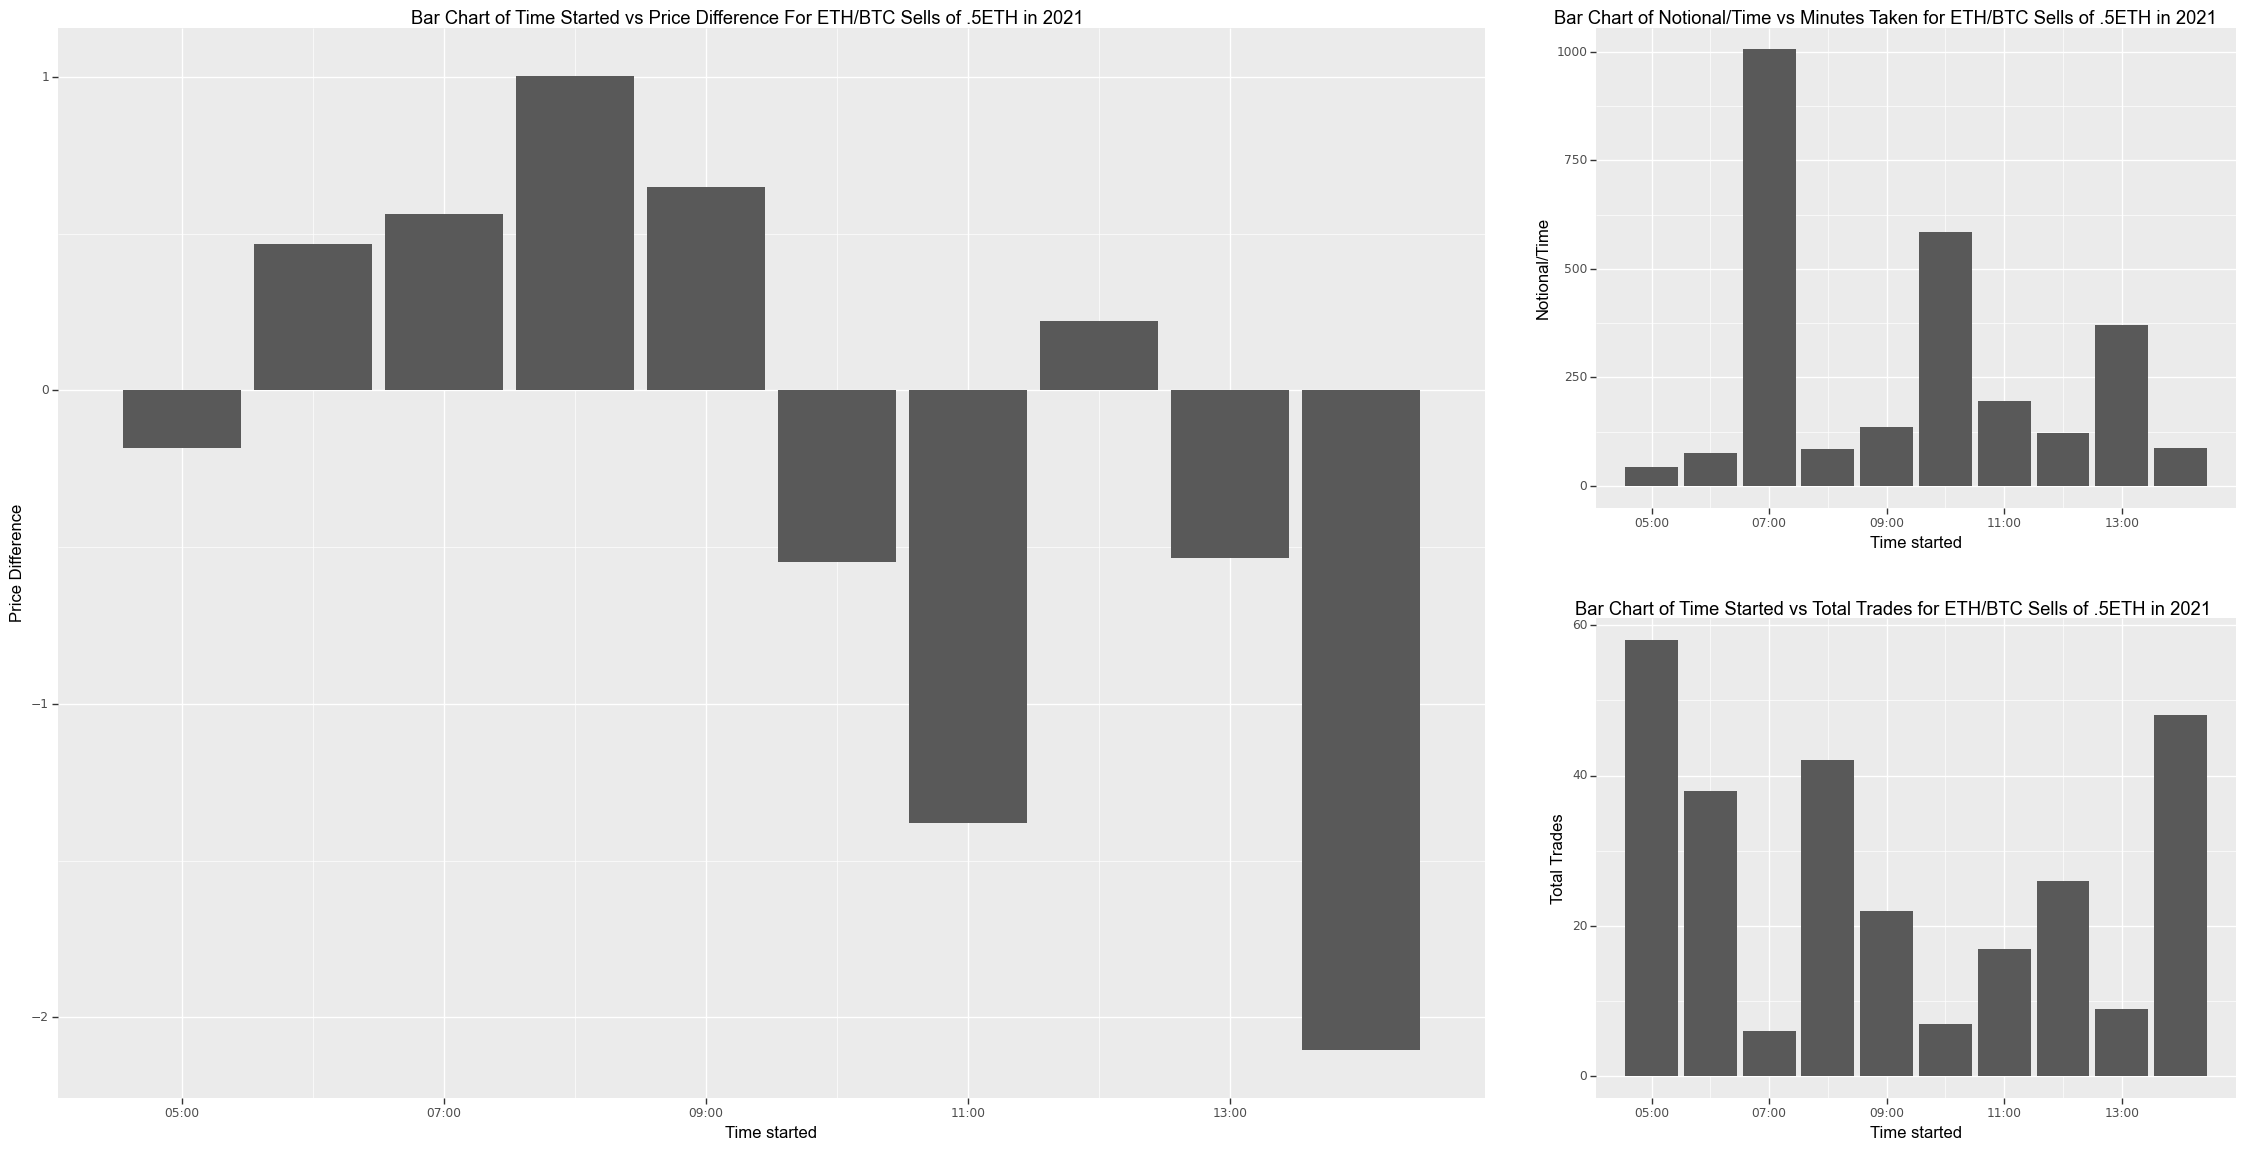

In [125]:
p1 = (ggplot(df_ETH_BTC_2021_S, aes(x='date', y='notional/time')) +
 geom_bar(stat='identity') +
 scale_x_date(date_breaks = "2 hours", date_labels = "%H:%M")+
 xlab('Time started') +
 ylab('Notional/Time') +
 ggtitle('Bar Chart of Notional/Time vs Minutes Taken for ETH/BTC Sells of .5ETH in 2021'))

p2 = (ggplot(df_ETH_BTC_2021_S, aes(x='date', y='total_trades')) +
 geom_bar(stat='identity') +
 scale_x_date(date_breaks = "2 hours", date_labels = "%H:%M")+
 xlab('Time started') +
 ylab('Total Trades') +
 ggtitle('Bar Chart of Time Started vs Total Trades for ETH/BTC Sells of .5ETH in 2021'))

p3 = (ggplot(df_ETH_BTC_2021_S, aes(x='date', y='price_difference')) +
 geom_bar(stat='identity') +
 scale_x_date(date_breaks = "2 hours", date_labels = "%H:%M")+
 xlab('Time started') +
 ylab('Price Difference') +
 ggtitle('Bar Chart of Time Started vs Price Difference For ETH/BTC Sells of .5ETH in 2021'))

p1 = pw.load_ggplot(p1)
p2 = pw.load_ggplot(p2)
p3 = pw.load_ggplot(p3)


p12 = ((p3 + p1/p2))
p12.savefig()

I then looped through each dataframe to create a master dataframe thad had the average of certain variables over that 10 hour period. i did this to reduce the variance and hopefully get more accurate measures of what the accumulation posibilities were like. The first part of the dataframe is the pair, followed by the year and either B or S for buy or sell. For ETH/BTC all of the variables were in BTC so I multiplied everything by the average price of BTC during that time period. The transaction costs for both buy and sell pairs will be very similar and almost identical due to the fact that I am accumulating the same amount in either a buy or sell trade, the fees are the same and the price of the currency remains practically the same. Also, the reason that average Notional/Time is noticably higher for ETH/BTC 2022 buys is because during one of the hours, the entire quantity was reached in one trade, making the average notional/time quite high as the time was effectively zero.

In [126]:

list_of_df = [df_BTC_USD_2021_B, df_BTC_USD_2021_S, df_BTC_USD_2022_B, df_BTC_USD_2022_S, df_BTC_USD_2023_B, df_BTC_USD_2023_S, df_ETH_USD_2021_B, df_ETH_USD_2021_S, df_ETH_USD_2022_B, df_ETH_USD_2022_S, df_ETH_USD_2023_B, df_ETH_USD_2023_S, df_ETH_BTC_2021_B, df_ETH_BTC_2021_S, df_ETH_BTC_2022_B, df_ETH_BTC_2022_S]
i = 0
analysis = pd.DataFrame(index =['df_BTC_USD_2021_B', 'df_BTC_USD_2021_S', 'df_BTC_USD_2022_B', 'df_BTC_USD_2022_S', 'df_BTC_USD_2023_B', 'df_BTC_USD_2023_S', 'df_ETH_USD_2021_B', 'df_ETH_USD_2021_S', 'df_ETH_USD_2022_B', 'df_ETH_USD_2022_S', 'df_ETH_USD_2023_B', 'df_ETH_USD_2023_S', 'df_ETH_BTC_2021_B', 'df_ETH_BTC_2021_S', 'df_ETH_BTC_2022_B', 'df_ETH_BTC_2022_S'], columns = ['Average Transaction Costs', 'Average Total Trades', 'Average Notional/Time', 'Average Minutes Spent', 'Average Price Difference', 'Year', 'Side'] )
for df in list_of_df:
    if i%6 == 0 or i%6 == 1:
        analysis['Year'][df.name] = 2021
    if i%6 == 2 or i%6 == 3:
        analysis['Year'][df.name] = 2022
    if i%6 == 4 or i%6 == 5:
        analysis['Year'][df.name] = 2023
    if i%2 == 0:
        analysis['Side'][df.name] = 'B'
    if i%2 == 1:
        analysis['Side'][df.name] = 'S'

    analysis['Average Transaction Costs'][df.name] = df.transaction_costs.mean()
    analysis['Average Total Trades'][df.name] = df.total_trades.mean()
    analysis['Average Notional/Time'][df.name] = df['notional/time'].mean()
    analysis['Average Minutes Spent'][df.name] = df.minutes_spent.mean()
    analysis['Average Price Difference'][df.name] = df.price_difference.mean()
    i+=1
     
analysis_BTC_USD = analysis.iloc[:6]
analysis_ETH_USD = analysis.iloc[6:12]
analysis_ETH_BTC = analysis.iloc[12:]
analysis_BTC_USD_buy = analysis_BTC_USD[analysis_BTC_USD.Side == 'B']
analysis_BTC_USD_sell = analysis_BTC_USD[analysis_BTC_USD.Side == 'S']
analysis_ETH_USD_buy = analysis_ETH_USD[analysis_ETH_USD.Side == 'B']
analysis_ETH_USD_sell = analysis_ETH_USD[analysis_ETH_USD.Side == 'S']
analysis_ETH_BTC_buy = analysis_ETH_BTC[analysis_ETH_BTC.Side == 'B']
analysis_ETH_BTC_sell = analysis_ETH_BTC[analysis_ETH_BTC.Side == 'S']
analysis

,Average Transaction Costs,Average Total Trades,Average Notional/Time,Average Minutes Spent,Average Price Difference,Year,Side
df_BTC_USD_2021_B,298.491658,492.8,7222.300406,11.603833,37.744686,2021,B
df_BTC_USD_2021_S,298.310363,214.7,6890.94837,10.708167,0.826523,2021,S
df_BTC_USD_2022_B,190.20916,502.1,5625.314928,7.789833,-5.65209,2022,B
df_BTC_USD_2022_S,190.258999,241.1,5355.954002,7.7055,4.60673,2022,S
df_BTC_USD_2023_B,113.194261,181.3,10201.940172,2.763667,-2.909791,2023,B
df_BTC_USD_2023_S,113.192007,125.9,10144.397718,3.142333,-2.516579,2023,S
df_ETH_USD_2021_B,106.771625,251.2,3196.772638,8.593167,1.980496,2021,B
df_ETH_USD_2021_S,106.713336,189.1,2246.87174,12.1265,0.652712,2021,S
df_ETH_USD_2022_B,130.611412,559.7,3238.001949,10.6535,0.280249,2022,B
df_ETH_USD_2022_S,130.617261,340.2,3585.776974,12.306167,0.376215,2022,S


### Average Price Difference

Another very noticable piece of information from this dataframe is that, besides BTC/USD buys in 2021, the alrogithm did very well to have average price difference very small. If you look at the bar charts above, you can see that for BTC/USD buys in 2021 almost all of the price differences were above zero, bringing the average up. This could be due to the fact that BTC was very volatile during this time period and just happened to be increasing as we were buying. It could also be due to the fact that there was less total volume in the market and these trades pushed the price of BTC up. Regardless of the reason, besides this date our algorithm achieved very steady price levels, which is one of the main goals of an accumulation algorithm. 

Below you can see the average price difference for buy and sell algorithms for ETH and BTC for the three year span. As mentioned, the only time that saw a lot of variation in price movement was 2021 for BTC buys.

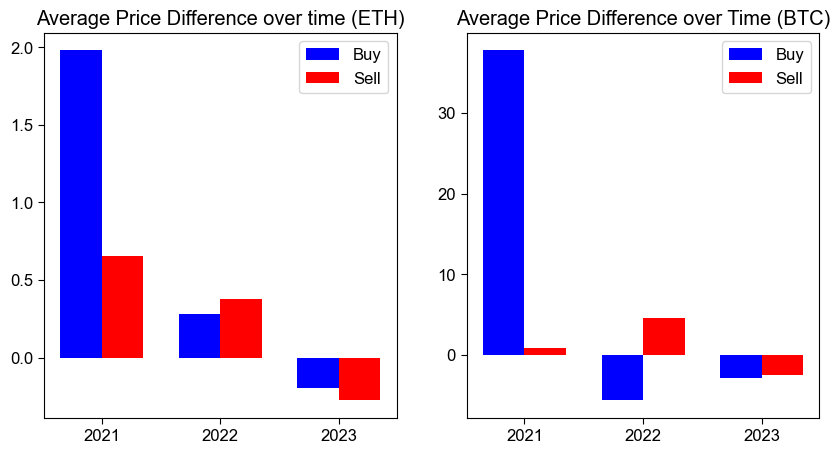

In [127]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
bar_width = 0.35
# plot the buy data
ax1.bar(analysis_ETH_USD_buy['Year'] - bar_width/2, analysis_ETH_USD_buy['Average Price Difference'], bar_width, label='Buy', color='blue')

# plot the sell data
ax1.bar(analysis_ETH_USD_sell['Year'] + bar_width/2, analysis_ETH_USD_sell['Average Price Difference'], bar_width, label='Sell', color='red')
ax1.set_xticks([2021, 2022, 2023])
ax1.legend()
ax1.set_title("Average Price Difference over time (ETH)")

ax2.bar(analysis_BTC_USD_buy['Year'] - bar_width/2, analysis_BTC_USD_buy['Average Price Difference'], bar_width, label='Buy', color='blue')

# create a bar chart for the sell data for Ethereum
ax2.bar(analysis_BTC_USD_sell['Year'] + bar_width/2, analysis_BTC_USD_sell['Average Price Difference'], bar_width, label='Sell', color='red')

# set the x-axis to only show the three years
ax2.set_xticks([2021, 2022, 2023])

# add a legend and title
ax2.legend()
ax2.set_title("Average Price Difference over Time (BTC)")
plt.show()

### Notional/Time

Notional/Time is defined as total transaction costs plus average price all divided by the total minutes taken. This can be a good measure of showing how much liquidity is in the market and normalizes the time taken as I tested it with inputs that had different total prices (1BTC in 2021 vs 2022 is 20,000$ difference). In the bar chart below you can see that liquidity seems to have grown over time in these crypto markets as Notional/Time is increasing from 2021 to 2023 which means the denominator (time) is getting smaller. Effectively, this means that you can accumulate more notional in crypto in a smaller amount of time.

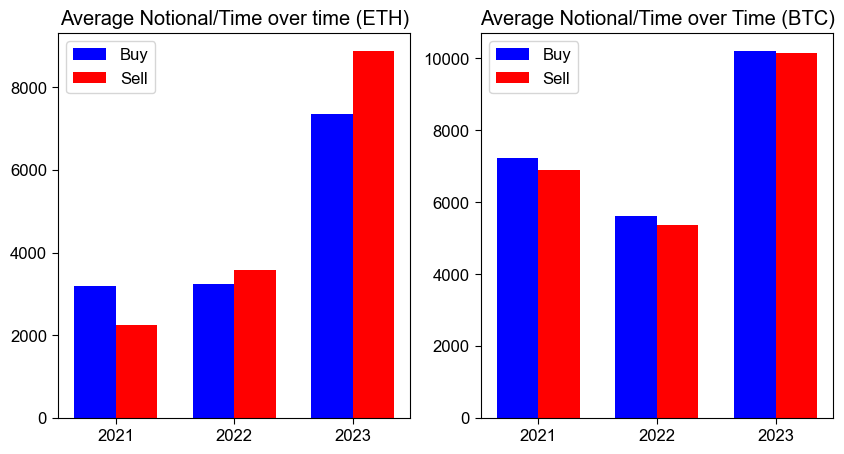

In [128]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
bar_width = 0.35
# plot the buy data
ax1.bar(analysis_ETH_USD_buy['Year'] - bar_width/2, analysis_ETH_USD_buy['Average Notional/Time'], bar_width, label='Buy', color='blue')

# plot the sell data
ax1.bar(analysis_ETH_USD_sell['Year'] + bar_width/2, analysis_ETH_USD_sell['Average Notional/Time'], bar_width, label='Sell', color='red')
ax1.set_xticks([2021, 2022, 2023])
ax1.legend()
ax1.set_title("Average Notional/Time over time (ETH)")

ax2.bar(analysis_BTC_USD_buy['Year'] - bar_width/2, analysis_BTC_USD_buy['Average Notional/Time'], bar_width, label='Buy', color='blue')

# create a bar chart for the sell data for Ethereum
ax2.bar(analysis_BTC_USD_sell['Year'] + bar_width/2, analysis_BTC_USD_sell['Average Notional/Time'], bar_width, label='Sell', color='red')

# set the x-axis to only show the three years
ax2.set_xticks([2021, 2022, 2023])

# add a legend and title
ax2.legend()
ax2.set_title("Average Notional/Time over Time (BTC)")
plt.show()

### Currency per Time period

Another test of this accumulation algorithm and liquidity in general is to see how much of each currency we can accumulate during a time constraint during these different years. For example, below I have shown how much BTC and notional I can accumulate for both buys and sells during our three years. I graphed notional as well as total BTC because the price of BTC fluctuates so much between the years that the graphs become unstandardized. 

In [129]:
btc_dict = {}
for i in (range(100)):
    s = accumulation_algorithm(i/10, 1618090132515484000, .05, BTC_USD, 15, 1)
    if s == 0:
        max = accumulation_algorithm((i-1)/10, 1618090132515484000, .05, BTC_USD, 15, 1)
        break
btc_dict['BTC_2021_B'] = [max['quantity'], max['total_spent'] + max['transaction_costs'], 2021, 'buy']

for i in (range(100)):
    s = accumulation_algorithm(i/10, 1618090132515484000, .05, BTC_USD, 15, -1)
    if s == 0:
        max = accumulation_algorithm((i-1)/10, 1618090132515484000, .05, BTC_USD, 15, -1)
        break
btc_dict['BTC_2021_S'] = [max['quantity'], max['total_spent']+ max['transaction_costs'], 2021, 'sell']


for i in (range(100)):
    s = accumulation_algorithm(i/10, 1643490169574850000, .05, BTC_USD, 15, 1)
    if s == 0:
        max = accumulation_algorithm((i-1)/10, 1643490169574850000, .05, BTC_USD, 15, 1)
        break
btc_dict['BTC_2022_B'] = [max['quantity'], max['total_spent'] + max['transaction_costs'], 2022, 'buy']

for i in (range(100)):
    s = accumulation_algorithm(i/10, 1643490169574850000, .05, BTC_USD, 15, -1)
    if s == 0:
        max = accumulation_algorithm((i-1)/10, 1643490169574850000, .05, BTC_USD, 15, -1)
        break
btc_dict['BTC_2022_S'] =[max['quantity'], max['total_spent'] + max['transaction_costs'], 2022, 'sell']


for i in (range(100)):
    s = accumulation_algorithm(i/10, 1674521267874527000, .05, BTC_USD, 15, 1)
    if s == 0:
        max = accumulation_algorithm((i-1)/10, 1674521267874527000, .05, BTC_USD, 15, 1)
        break
btc_dict['BTC_2023_B'] =[max['quantity'], max['total_spent'] + max['transaction_costs'], 2023, 'buy']

for i in (range(100)):
    s = accumulation_algorithm(i/10, 1674521267874527000, .05, BTC_USD, 15, -1)
    if s == 0:
        max = accumulation_algorithm((i-1)/10, 1674521267874527000, .05, BTC_USD, 15, -1)
        break
btc_dict['BTC_2023_S'] = [max['quantity'], max['total_spent'] + max['transaction_costs'], 2023, 'sell']


x = pd.DataFrame.from_dict(btc_dict)
x.index = (['Total BTC', 'Total Notional', 'Year', 'Side'])
x = x.T


unable to accumulate this amount in the time constraint!
unable to accumulate this amount in the time constraint!
unable to accumulate this amount in the time constraint!
unable to accumulate this amount in the time constraint!
unable to accumulate this amount in the time constraint!
unable to accumulate this amount in the time constraint!


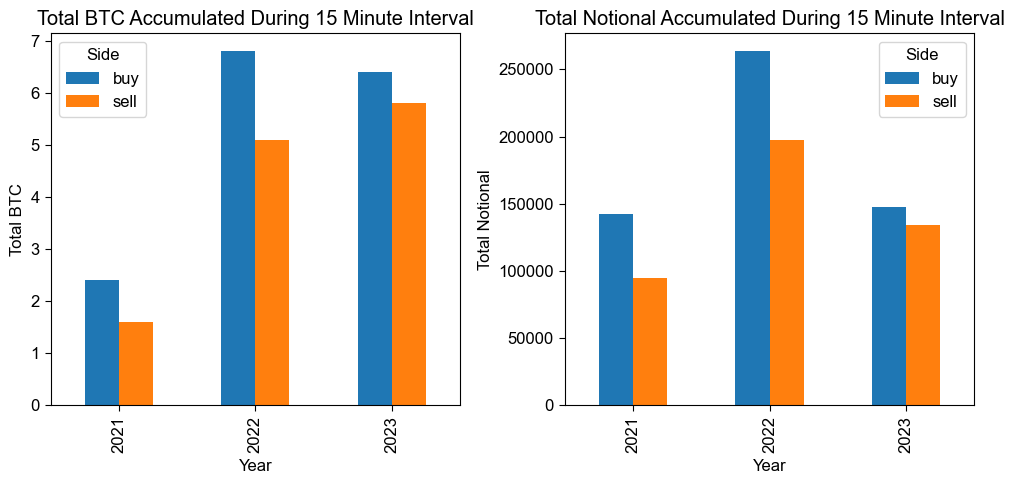

In [130]:
grouped = x.groupby(['Year', 'Side']).sum()
unstacked_btc = grouped['Total BTC'].unstack(level=-1)
unstacked_notional = grouped['Total Notional'].unstack(level=-1)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

unstacked_btc.plot(kind='bar', stacked=False, ax=axs[0])
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Total BTC')
axs[0].set_title('Total BTC Accumulated During 15 Minute Interval')
axs[0].legend(title='Side')

unstacked_notional.plot(kind='bar', stacked=False, ax=axs[1])
axs[1].set_xlabel('Year')
axs[1].set_ylabel('Total Notional')
axs[1].set_title('Total Notional Accumulated During 15 Minute Interval')
axs[1].legend(title='Side')

# Show the plot
plt.tight_layout()
plt.show()

This graph shows us slightly different results than the Time/Notional metric as it seems as though more accumualation was possible during 2022. In the Time/Notional graphs it seemed that we were able to accumulate notional the quickest in 2023 but we were also only accumulating 1 BTC, in 2022 there may be more BTC trades available and therefore we can accumulate more notional. Also, these graphs show us that our buy accumulations seem to be able to accumlate more BTC than sells in all years.

The economic intuition behind this in my opinion is due to the fact that the 'crypto craze' was really taking off in 2021 and 2022. In 2022 we seem to be able to accumulate the most becasue there are more trades going on due to increased interest. Also, during this time, more people seem to be buying crypto than selling it since it had dipped down from 60k and people were buying, waiting for it to go back up. In 2023, we see the margin between our buy and sell algorithms start to shrink as crypto prices drop even more, and there are almost an even amount of both buys and sells during our tested period.

# 4 Conclusions

According to my outputs and analysis, it seems as though my accumulation algorithm successfully allows us to buy/sell crypto in small increments and keep the VWAP and initial price relatively similar. During my analysis I concluded that due to increaesed liquidity in 2022 and 2023, accumulation became easier and more efficient. Certain aspects that I could improve in my algorithm and algorithm testing is to test it on more data than just a two day period, as I am making my assumptions for 2022 based on a tiny two day period at the start of the year. Accumulation possibilities in January are most likely very different than opportunities in June due to the everchanging market. 